## **LIBRARY IMPORTS**

In [43]:
# Import Libraries
import cudf
import os
import joblib
import pywt
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wfdb  # For reading MIT-BIH data
import keras_tuner as kt
import seaborn as sns
import tensorflow as tf
import neurokit2 as nk

# Scikit-learn and Imbalanced-learn imports
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    precision_recall_curve,
    auc,
    f1_score,
    precision_score,
    recall_score,
    accuracy_score
)
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline
from scipy.stats import entropy
from collections import Counter
from scipy.signal import find_peaks, resample, butter, filtfilt, iirnotch, spectrogram
from sklearn.utils import class_weight
from glob import glob

# Model imports
from sklearn.svm import SVC
from imblearn.ensemble import BalancedRandomForestClassifier
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, MaxPooling1D, Dropout, Add, GlobalAveragePooling1D, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from cuml.ensemble import RandomForestClassifier
from scikeras.wrappers import KerasClassifier
from sklearn.utils.class_weight import compute_class_weight

# Additional setups
# Checking cUML
print(cudf.Series([1, 2, 3]))

# Setting TensorFlow flags
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Checking GPU
gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
    print(f"TensorFlow has detected {len(gpu_devices)} GPU(s):")
    for device in gpu_devices:
        print(f"- {device}")
else:
    print("TensorFlow did not detect any GPUs. Training will run on the CPU.")


0    1
1    2
2    3
dtype: int64
TensorFlow has detected 1 GPU(s):
- PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## **DATA PREPARATION**

### DATA PREPARATION FUNCTIONS
1. prepare_cnn_data
* Purpose: This function is the core processor for the MIT-BIH Arrhythmia Database. It takes the raw ECG signals and their corresponding annotations to generate labeled, windowed segments of the signal, which serve as the direct input for the 1D-CNN.
* Key Steps:
    1) Signal Denoising: It first applies the preprocess_signal function to remove noise like baseline wander and powerline interference.
    2) Resampling: The signal's frequency is resampled from the original 360 Hz to a target of 500 Hz to standardize the data.
    3) R-Peak Alignment: It adjusts the locations of the R-peaks (the most prominent part of a heartbeat) to match the new, higher sampling rate.
    4) Windowing: For each annotated heartbeat, it extracts a fixed-size window of the signal (400 samples, or 0.8 seconds). The R-peak is used as the central anchor point for this window.
    5) Labeling: Each extracted window is assigned a numerical label based on the AAMI class mapping (e.g., 'N' for Normal becomes 0).
* Output: The function returns two arrays: one containing the raw signal windows (the data, or X) and another containing their corresponding numerical labels (the targets, or y).

2. prepare_cnn_data_from_bin
* Purpose: This function is designed to process ECG data from custom binary (.bin) files. It mirrors the functionality of prepare_cnn_data but is adapted for datasets that do not have pre-existing annotation files like the MIT-BIH database.
* Key Steps:
    1) Signal Denoising: Just like the previous function, it cleans the raw signal to ensure quality.
    2) R-Peak Detection: Since no annotation file is available, it uses the detect_r_peaks_robust function to automatically identify the R-peak locations in the signal.
    3) Windowing: It segments the signal into windows around each detected R-peak.
    4) Uniform Labeling: Unlike the MIT-BIH function, all windows extracted from a single .bin file are assigned the same label, which is provided as an argument to the function (e.g., all beats from ecg_normal.bin are labeled as 0).
* Output: It returns arrays of raw signal windows and their corresponding labels, ready to be used as a final testing set.
3. Database: MIT-BIH Arrhythmia Database & additional ECG data with a format of .bin files and from heartbeat simulator
4. Preparation: Raw data for 1D-CNN

In [44]:
# --- CONFIGURATION ---
label_map = {
    'N': 0, '.': 0, 'L': 0, 'R': 0, 'e': 0, 'j': 0,
    'V': 1, 'E': 1,
    'S': 2, 'A': 2, 'a': 2, 'J': 2,
    'F': 3
}

class_names_map = {
    0: 'Normal (N)', 1: 'Ventricular (V)', 2: 'Supraventricular (S)',
    3: 'Fusion (F)'
}

# --- PATHS AND CONSTANTS ---
DB_PATH_MIT = '../data/raw/MIT-BIH/mit-bih-arrhythmia-database-1.0.0/mit-bih-arrhythmia-database-1.0.0/'
FS_TARGET = 360
WINDOW_SIZE = 288

RECORDS_TRAIN = [
    '101', '106', '108', '109', '112', '114', '115', '116', '118', '119',
    '122', '124', '201', '203', '205', '207', '208', '209', '215', '220',
    '223', '230'
]
RECORDS_TEST = [
    '100', '103', '105', '111', '113', '117', '121', '123', '200', '202',
    '210', '212', '213', '214', '219', '221', '222', '228', '231', '232',
    '233', '234'
]

output_dir = '../data/processed/CNN-only'
os.makedirs(output_dir, exist_ok=True)

# --- PREPROCESSING & UTILITIES ---
def preprocess_signal(signal, fs):
    signal = np.array(signal)
    nyq = 0.5 * fs
    b, a = butter(2, 0.5 / nyq, btype='high')
    signal_bw_removed = filtfilt(b, a, signal)
    b, a = iirnotch(60, Q=30, fs=fs)
    cleaned_signal = filtfilt(b, a, signal_bw_removed)
    return cleaned_signal

def visualize_preprocessing_result(raw_signal, fs, record_name=""):
    print(f"Visualizing preprocessing for record: {record_name} (first 10 seconds)...")
    snippet_length = int(10 * fs)
    raw_snippet = raw_signal[:snippet_length]
    cleaned_snippet = preprocess_signal(raw_snippet, fs=fs)
    time_axis = np.arange(len(raw_snippet)) / fs
    plt.figure(figsize=(15, 6))
    plt.plot(time_axis, raw_snippet, label='Raw Signal', color='blue', alpha=0.7)
    plt.plot(time_axis, cleaned_snippet, label='Cleaned Signal', color='red', linewidth=1.5)
    plt.title(f'ECG Signal Preprocessing Result for Record {record_name}')
    plt.xlabel('Time (seconds)'); plt.ylabel('Amplitude (mV)')
    plt.legend(); plt.grid(True, linestyle='--', alpha=0.6); plt.show()

def plot_class_distribution(labels, title, class_map):
    """Generates a bar plot of the class distribution."""
    counts = Counter(labels)
    class_indices = sorted(counts.keys())
    class_names = [class_map[i] for i in class_indices]
    class_counts = [counts[i] for i in class_indices]

    plt.figure(figsize=(10, 6))
    sns.barplot(x=class_names, y=class_counts)
    plt.title(title, fontsize=16)
    plt.ylabel('Number of Samples', fontsize=12)
    plt.xlabel('Arrhythmia Class', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# --- DATA LOADING AND SEGMENTATION ---
def load_and_prepare_cnn_data(db_path, record_names, window_size, fs):
    all_windows, all_labels = [], []
    samples_before = window_size // 2
    samples_after = window_size - samples_before
    print(f"Loading and processing records: {', '.join(record_names)}...")
    for rec_name in record_names:
        record_path = os.path.join(db_path, rec_name)
        try:
            record = wfdb.rdrecord(record_path, channels=[0])
            annotation = wfdb.rdann(record_path, 'atr')
            raw_signal = record.p_signal.flatten()
            cleaned_signal = preprocess_signal(raw_signal, fs=fs)
            cleaned_signal = (cleaned_signal - np.mean(cleaned_signal)) / np.std(cleaned_signal)
            for i, r_peak_loc in enumerate(annotation.sample):
                symbol = annotation.symbol[i]
                if symbol in label_map:
                    start, end = r_peak_loc - samples_before, r_peak_loc + samples_after
                    if start >= 0 and end < len(cleaned_signal):
                        window = cleaned_signal[start:end]
                        if len(window) == window_size:
                            all_windows.append(np.expand_dims(window, axis=-1))
                            all_labels.append(label_map[symbol])
        except Exception as e:
            print(f"Error processing record {rec_name}: {e}")
    print("Data loading and preparation complete.")
    return np.array(all_windows), np.array(all_labels)

### DATA PREPARATION EXECUTION

--- Starting Data Preparation for 1D-CNN Model ---

--- [Step 1] Processing MIT-BIH Training Data (DS1) ---
Loading and processing records: 101, 106, 108, 109, 112, 114, 115, 116, 118, 119, 122, 124, 201, 203, 205, 207, 208, 209, 215, 220, 223, 230...
Data loading and preparation complete.
Full training data shapes -> Windows: (50990, 288, 1), Labels: (50990,)
Visualizing preprocessing for record: 101 (first 10 seconds)...


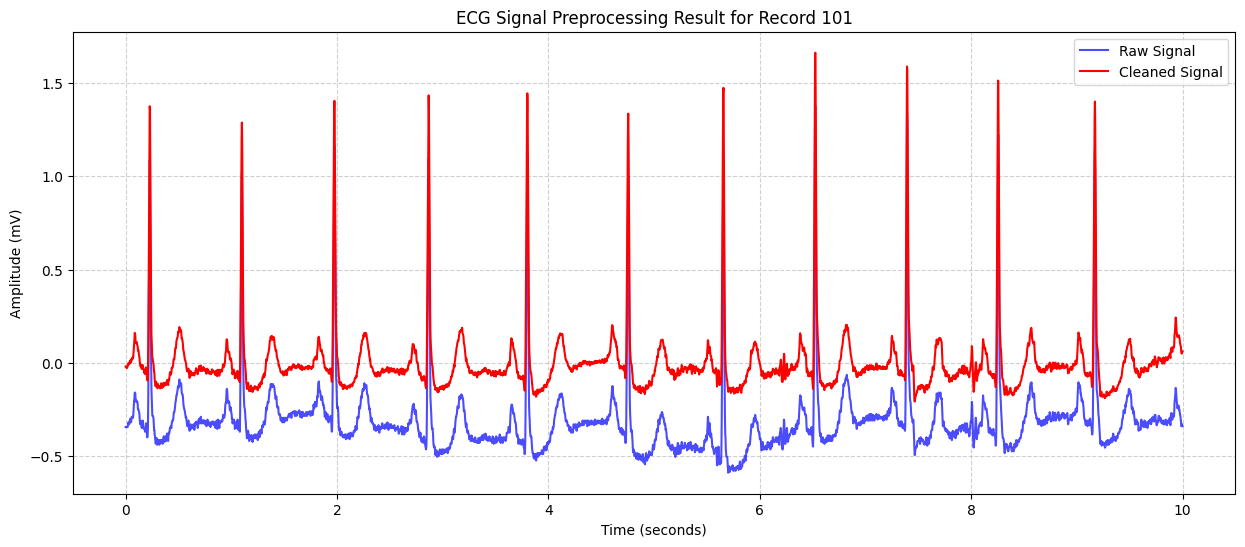


--- [Step 2] Processing MIT-BIH Testing Data (DS2) ---
Loading and processing records: 100, 103, 105, 111, 113, 117, 121, 123, 200, 202, 210, 212, 213, 214, 219, 221, 222, 228, 231, 232, 233, 234...
Data loading and preparation complete.
Testing data shapes -> Windows: (49683, 288, 1), Labels: (49683,)

--- [Step 3] Splitting full training data into training and validation sets ---
Train set shape after split: (40792, 288, 1)
Validation set shape after split: (10198, 288, 1)
Class distribution in training set before resampling: Counter({np.int64(0): 36675, np.int64(1): 3031, np.int64(2): 755, np.int64(3): 331})


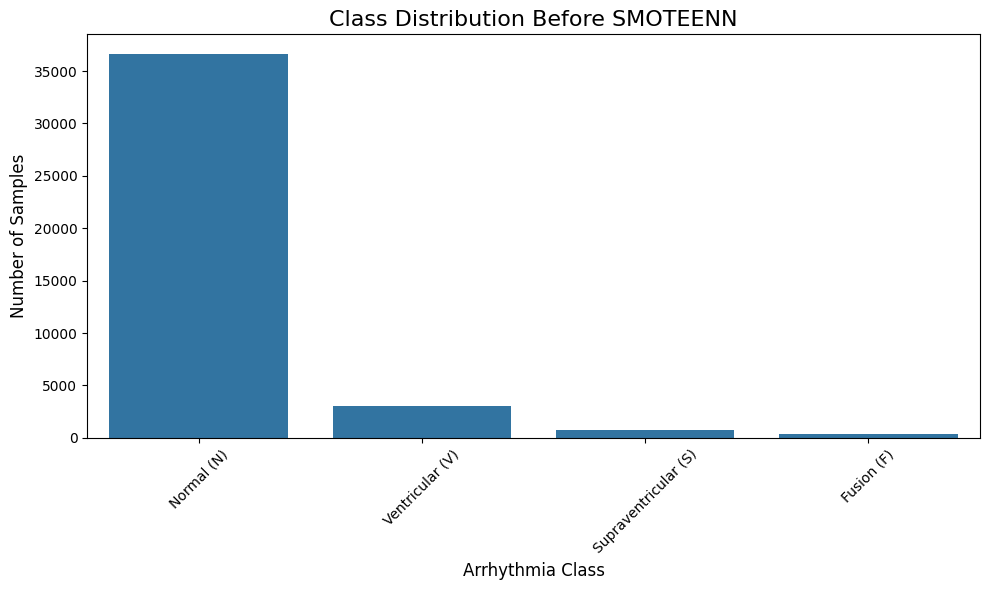


--- [Step 4] Applying SMOTEENN to the training set to handle imbalance ---
Train set shape after resampling: (146258, 288, 1)
Class distribution in training set after resampling: Counter({np.int64(2): 36674, np.int64(3): 36674, np.int64(1): 36658, np.int64(0): 36252})


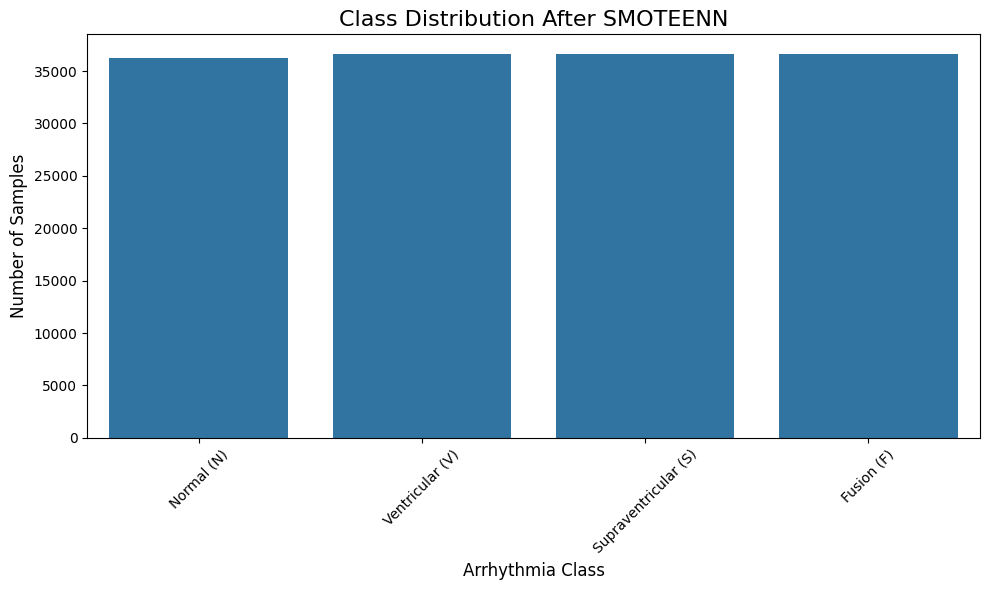


--- [Step 5] One-hot encoding labels for training and validation sets ---
Shape of one-hot encoded y_train: (146258, 4)

--- [Step 6] Saving datasets to '../data/processed/CNN-only' ---

✅ DATA PREPARATION COMPLETE ✅
Data saved in: /mnt/c/Users/OSOTNAS/Documents/Kean/Others/KP_Xirka-Darma-Persada/machine-learning/data/processed/CNN-only


In [45]:
# --- MAIN EXECUTION SCRIPT ---
if __name__ == '__main__':
    print("--- Starting Data Preparation for 1D-CNN Model ---")
    print("\n--- [Step 1] Processing MIT-BIH Training Data (DS1) ---")
    X_train_full, y_train_full = load_and_prepare_cnn_data(DB_PATH_MIT, RECORDS_TRAIN, WINDOW_SIZE, FS_TARGET)
    print(f"Full training data shapes -> Windows: {X_train_full.shape}, Labels: {y_train_full.shape}")

    try:
        first_train_rec = wfdb.rdrecord(os.path.join(DB_PATH_MIT, RECORDS_TRAIN[0]), channels=[0])
        visualize_preprocessing_result(first_train_rec.p_signal.flatten(), fs=FS_TARGET, record_name=RECORDS_TRAIN[0])
    except Exception as e:
        print(f"Could not visualize preprocessing for {RECORDS_TRAIN[0]}: {e}")

    print("\n--- [Step 2] Processing MIT-BIH Testing Data (DS2) ---")
    X_test, y_test = load_and_prepare_cnn_data(DB_PATH_MIT, RECORDS_TEST, WINDOW_SIZE, FS_TARGET)
    print(f"Testing data shapes -> Windows: {X_test.shape}, Labels: {y_test.shape}")

    print("\n--- [Step 3] Splitting full training data into training and validation sets ---")
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full
    )
    print(f"Train set shape after split: {X_train.shape}")
    print(f"Validation set shape after split: {X_val.shape}")
    print(f"Class distribution in training set before resampling: {Counter(y_train)}")
    plot_class_distribution(y_train, "Class Distribution Before SMOTEENN", class_names_map)

    print("\n--- [Step 4] Applying SMOTEENN to the training set to handle imbalance ---")
    # Reshape X_train from 3D to 2D for SMOTEENN
    n_samples, window_size, channels = X_train.shape
    X_train_reshaped = X_train.reshape((n_samples, window_size * channels))

    # Initialize and apply the sampler
    sampler = SMOTEENN(random_state=42)
    X_train_resampled, y_train_resampled = sampler.fit_resample(X_train_reshaped, y_train)

    # Reshape X_train back to 3D for the CNN
    X_train = X_train_resampled.reshape((X_train_resampled.shape[0], window_size, channels))
    y_train = y_train_resampled

    print(f"Train set shape after resampling: {X_train.shape}")
    print(f"Class distribution in training set after resampling: {Counter(y_train)}")
    plot_class_distribution(y_train, "Class Distribution After SMOTEENN", class_names_map)


    print("\n--- [Step 5] One-hot encoding labels for training and validation sets ---")
    num_classes = len(np.unique(y_train_full))
    y_train_cat = to_categorical(y_train, num_classes=num_classes)
    y_val_cat = to_categorical(y_val, num_classes=num_classes)
    print(f"Shape of one-hot encoded y_train: {y_train_cat.shape}")

    print(f"\n--- [Step 6] Saving datasets to '{output_dir}' ---")
    np.save(os.path.join(output_dir, 'X_train_cnn.npy'), X_train)
    np.save(os.path.join(output_dir, 'y_train_cnn.npy'), y_train_cat)
    np.save(os.path.join(output_dir, 'X_val_cnn.npy'), X_val)
    np.save(os.path.join(output_dir, 'y_val_cnn.npy'), y_val_cat)
    np.save(os.path.join(output_dir, 'X_test_cnn.npy'), X_test)
    np.save(os.path.join(output_dir, 'y_test_cnn.npy'), y_test)

    print("\n" + "="*60)
    print("✅ DATA PREPARATION COMPLETE ✅")
    print(f"Data saved in: {os.path.abspath(output_dir)}")
    print("="*60)


## **MACHINE LEARNING MODEL TRAINING & SAVING**

### MACHINE LEARNING MODEL FUNCTIONS
The used model is optimized 1D-CNN.

In [46]:
def create_cnn_model(input_shape, output_dim, hp=None):
    """
    Creates and compiles an optimized 1D-CNN model.
    If 'hp' is provided, it builds a tunable model for KerasTuner.
    Otherwise, it builds a model with default hyperparameters.
    """
    # Define a default hyperparameter object if none is passed
    if hp is None:
        hp = kt.HyperParameters()
        # Set default values for when not tuning
        hp.values['conv4_filters'] = 64
        hp.values['dense_units'] = 118
        hp.values['learning_rate'] = 0.001

    inputs = Input(shape=input_shape)
    x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='valid', name='conv1d_1_freezed')(inputs)
    x = MaxPooling1D(pool_size=2, name='maxpool1d_1_freezed')(x)
    x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', name='conv1d_2_freezed')(x)
    x = MaxPooling1D(pool_size=2, name='maxpool1d_2_freezed')(x)
    x = Conv1D(filters=4, kernel_size=3, activation='relu', padding='same', name='conv1d_3_freezed')(x)
    x = MaxPooling1D(pool_size=2, name='maxpool1d_3_freezed')(x)
    # ===============================================
    #           Trainable Layers
    # ===============================================
    x = Conv1D(filters=hp.values['conv4_filters'], kernel_size=3, activation='relu', padding='same', name='conv1d_4_trainable')(x)
    x = Flatten(name='flatten_layer')(x)
    x = Dense(units=hp.values['dense_units'], activation='relu', name='dense_1_trainable')(x)
    outputs = Dense(units=output_dim, activation='softmax', name='output_layer_trainable')(x)
    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(
        optimizer=Adam(learning_rate=hp.values['learning_rate']),
        loss='categorical_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.F1Score(average='weighted', name='f1_score'),
            tf.keras.metrics.SpecificityAtSensitivity(0.9, name='specificity')
        ]
    )
    return model

### MACHINE LEARNING MODEL TRAINING EXECUTION
1. Targeted metrics: Precision, Recall, F1-Score, and Specificity
2. There are 3 executions: multiple models training (1D-CNN, BalancedRandomForest, and MLP), MLP model specific training, and MLP model automatic hyperparameter tuning
3. After training, all models immediately saved and exported into a certain folder

In [19]:
# --- Ten-Fold Cross Validation for CNN model---
# Define input and output dimensions for the CNN model
# We combine the initial training and validation sets for cross-validation
X_full_train = np.concatenate((X_train_cnn, X_val_cnn), axis=0)
y_full_train_cat = np.concatenate((y_train_cnn, y_val_cnn), axis=0)
y_full_train = np.argmax(y_full_train_cat, axis=1) # Get 1D labels for splitting

input_shape_cnn = (X_full_train.shape[1], X_full_train.shape[2])
output_dim = y_full_train_cat.shape[1]
class_names = ['Normal (N)', 'Ventricular (V)', 'Supraventricular (S)', 'Fusion (F)']

# Define the output directory for saving the model
output_dir = '../models'
os.makedirs(output_dir, exist_ok=True)

# --- 10-Fold Cross-Validation ---
n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Lists to store metrics for each fold
fold_accuracies = []
fold_f1_scores = []
fold_losses = []

print(f"\n{'='*20} STARTING {n_splits}-FOLD CROSS-VALIDATION {'='*20}")

for fold, (train_index, val_index) in enumerate(skf.split(X_full_train, y_full_train)):
    print(f"\n--- FOLD {fold + 1}/{n_splits} ---")

    # Split the data for the current fold
    X_train, X_val = X_full_train[train_index], X_full_train[val_index]
    y_train_cat, y_val_cat = y_full_train_cat[train_index], y_full_train_cat[val_index]
    y_train = y_full_train[train_index] # 1D labels for weight calculation

    # --- Manual Class Weights Calculation for the current fold ---
    print("Calculating class weights for the current fold...")
    n_samples = len(y_train)
    class_counts = Counter(y_train)
    n_classes = len(class_counts)
    
    manual_weights = {}
    print("Manual Calculation Breakdown:")
    for i in range(n_classes):
        n_samples_in_class = class_counts.get(i, 0) # Use .get for safety
        weight = n_samples / (n_classes * n_samples_in_class)
        manual_weights[i] = weight
        print(f"  Weight for Class {i} ({class_names[i]}): {n_samples} / ({n_classes} * {n_samples_in_class}) = {weight:.4f}")
    
    class_weights_dict = dict(manual_weights)
    print("Fold Weights:", class_weights_dict)

    # --- Model Creation (re-create model for each fold) ---
    model = create_cnn_model(input_shape_cnn, output_dim)

    # --- Model Training for the current fold ---
    print("Training...")
    history = model.fit(
        X_train, y_train_cat,
        epochs=150,
        batch_size=100,
        verbose=0, # Set to 0 to keep output clean during CV
        validation_data=(X_val, y_val_cat),
        class_weight=class_weights_dict
    )

    # --- Evaluate the fold ---
    # FIX: Unpack all returned values from model.evaluate into a list
    # The first value is always loss, the second is the first metric (accuracy)
    evaluation_results = model.evaluate(X_val, y_val_cat, verbose=0)
    loss = evaluation_results[0]
    accuracy = evaluation_results[1]
    
    # Get predictions to calculate F1-score
    y_val_pred_raw = model.predict(X_val, verbose=0)
    y_val_pred = np.argmax(y_val_pred_raw, axis=1)
    y_val_true = np.argmax(y_val_cat, axis=1)
    
    # Calculate macro F1-score, which is suitable for imbalanced classes
    f1 = f1_score(y_val_true, y_val_pred, average='macro', zero_division=0)
    
    fold_losses.append(loss)
    fold_accuracies.append(accuracy)
    fold_f1_scores.append(f1) # Append F1-score
    print(f"Fold {fold + 1} - Val Loss: {loss:.4f}, Val Accuracy: {accuracy:.4f}, Val Macro F1-Score: {f1:.4f}")

# --- Average Cross-Validation Results ---
print(f"\n{'='*20} CROSS-VALIDATION SUMMARY {'='*20}")
print(f"Average Validation Accuracy: {np.mean(fold_accuracies):.4f} (+/- {np.std(fold_accuracies):.4f})")
print(f"Average Validation F1-Score: {np.mean(fold_f1_scores):.4f} (+/- {np.std(fold_f1_scores):.4f})")
print(f"Average Validation Loss: {np.mean(fold_losses):.4f}")


# --- Final Model Training on ALL Data ---
print(f"\n{'='*20} TRAINING FINAL MODEL ON ALL DATA {'='*20}")
# Re-calculate weights on the full training dataset
full_train_class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_full_train), y=y_full_train)
full_train_class_weights_dict = dict(enumerate(full_train_class_weights))
print("Final Model Weights:", full_train_class_weights_dict)

final_model = create_cnn_model_optimized(input_shape_cnn, output_dim)
final_model.fit(
    X_full_train, y_full_train_cat,
    epochs=150,
    batch_size=100,
    verbose=1,
    class_weight=full_train_class_weights_dict
)

# --- Final Evaluation on the Hold-Out Test Set ---
print(f"\n{'='*20} FINAL EVALUATION ON TEST SET {'='*20}")
y_pred_raw = final_model.predict(X_test_cnn)
y_pred = np.argmax(y_pred_raw, axis=1)
y_true = y_test_final

# --- Final Evaluation Report ---
print(f"\n{'~'*15} REPORT FOR FINAL MODEL {'~'*15}")
print("\nClassification Report:")
report = classification_report(y_true, y_pred, target_names=class_names, zero_division=0)
print(report)

# --- Confusion Matrix Visualization ---
print("Confusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix for Final 1D-CNN Model', fontsize=16)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.show()

# --- Saving the Final Model ---
print(f"\n--- Saving final model: 1D-CNN ---")
model_path = os.path.join(output_dir, "model_1d-cnn_final.keras")
final_model.save(model_path)
print(f"✅ Final Model 1D-CNN has been saved on: {model_path}")

AxisError: axis 1 is out of bounds for array of dimension 1

--- [1] Loading pre-split datasets ---
Loaded training data shapes -> X: (146258, 288, 1), y: (146258, 4)
Loaded validation data shapes -> X: (10198, 288, 1), y: (10198, 4)
Loaded test data shapes -> X: (49683, 288, 1), y: (49683,)

--- [2] Defining model parameters ---
Input Shape: (288, 1)
Output Dimension (Number of Classes): 4

--- [3] Calculating class weights for the training set ---
Manual Calculation Breakdown:
  Weight for Class 0 (Normal (N)): 146258 / (4 * 36252) = 1.0086
  Weight for Class 1 (Ventricular (V)): 146258 / (4 * 36658) = 0.9974
  Weight for Class 2 (Supraventricular (S)): 146258 / (4 * 36674) = 0.9970
  Weight for Class 3 (Fusion (F)): 146258 / (4 * 36674) = 0.9970
Final Fold Weights: {0: 1.0086202140571554, 1: 0.9974493971302307, 2: 0.997014233516933, 3: 0.997014233516933}

--- [4] Creating 1D-CNN Model ---


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 288, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1_freezed (Conv1D)       │ (None, 286, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool1d_1_freezed             │ (None, 143, 64)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2_freezed (Conv1D)       │ (None, 143, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool1d_2_freezed             │ (None, 71, 64)         │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3_freezed (Conv1D)       │ (None, 71, 4)          │           772 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool1d_3_freezed             │ (None, 35, 4)          │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4_trainable (Conv1D)     │ (None, 35, 64)         │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_layer (Flatten)         │ (None, 2240)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1_trainable (Dense)       │ (None, 118)            │       264,438 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer_trainable (Dense)  │ (None, 4)              │           476 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 279,126 (1.06 MB)

 Trainable params: 279,126 (1.06 MB)

 Non-trainable params: 0 (0.00 B)


--- [5] Training 1D-CNN Model ---
Epoch 1/150
1463/1463 ━━━━━━━━━━━━━━━━━━━━ 37s 17ms/step - accuracy: 0.9739 - f1_score: 0.9739 - loss: 0.0805 - precision: 0.9797 - recall: 0.9676 - specificity: 0.9988 - val_accuracy: 0.9842 - val_f1_score: 0.9848 - val_loss: 0.0623 - val_precision: 0.9847 - val_recall: 0.9838 - val_specificity: 0.9992
Epoch 2/150
1463/1463 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.9955 - f1_score: 0.9955 - loss: 0.0152 - precision: 0.9956 - recall: 0.9955 - specificity: 0.9999 - val_accuracy: 0.9902 - val_f1_score: 0.9903 - val_loss: 0.0475 - val_precision: 0.9904 - val_recall: 0.9902 - val_specificity: 0.9993
Epoch 3/150
1463/1463 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9976 - f1_score: 0.9976 - loss: 0.0085 - precision: 0.9976 - recall: 0.9975 - specificity: 0.9999 - val_accuracy: 0.9846 - val_f1_score: 0.9856 - val_loss: 0.0678 - val_precision: 0.9849 - val_recall: 0.9842 - val_specificity: 0.9990
Epoch 4/150
1463/1463 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/

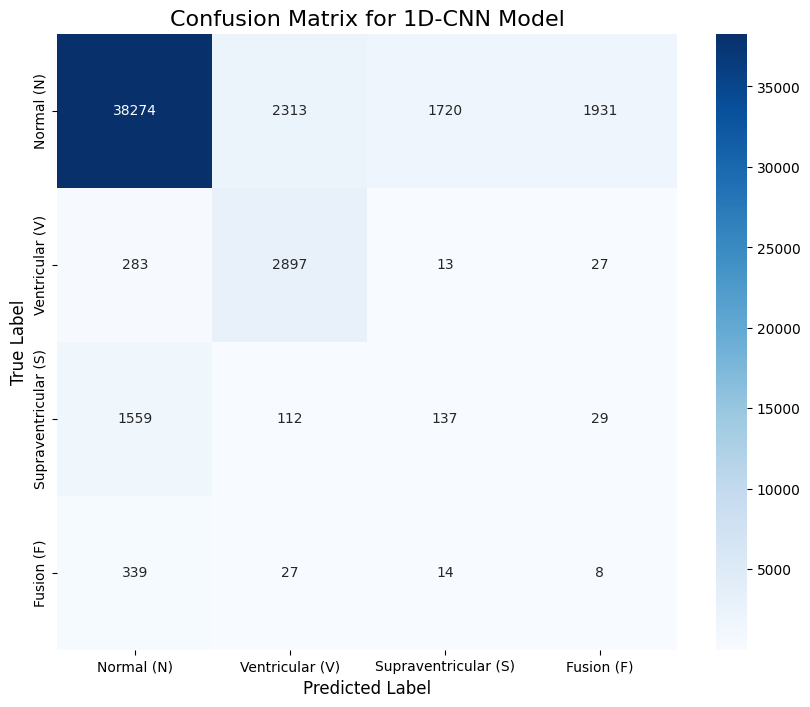


--- [7] Saving the final model ---
✅ Model has been saved to: ../models/model_1d_cnn_single.keras


In [48]:
# --- [1] LOAD PREPARED, PRE-SPLIT DATA ---
print("--- [1] Loading pre-split datasets ---")
PROCESSED_DATA_DIR = '../data/processed/CNN-only'

# Load the training, validation, and test sets directly
X_train = np.load(os.path.join(PROCESSED_DATA_DIR, 'X_train_cnn.npy'))
y_train_cat = np.load(os.path.join(PROCESSED_DATA_DIR, 'y_train_cnn.npy'))

X_val = np.load(os.path.join(PROCESSED_DATA_DIR, 'X_val_cnn.npy'))
y_val_cat = np.load(os.path.join(PROCESSED_DATA_DIR, 'y_val_cnn.npy'))

X_test = np.load(os.path.join(PROCESSED_DATA_DIR, 'X_test_cnn.npy'))
y_test = np.load(os.path.join(PROCESSED_DATA_DIR, 'y_test_cnn.npy')) # This is 1D for final eval

print(f"Loaded training data shapes -> X: {X_train.shape}, y: {y_train_cat.shape}")
print(f"Loaded validation data shapes -> X: {X_val.shape}, y: {y_val_cat.shape}")
print(f"Loaded test data shapes -> X: {X_test.shape}, y: {y_test.shape}")


# --- [2] DEFINE MODEL PARAMETERS ---
print("\n--- [2] Defining model parameters ---")
input_shape_cnn = (X_train.shape[1], X_train.shape[2])
output_dim = y_train_cat.shape[1] # Get num_classes from one-hot encoded shape

print(f"Input Shape: {input_shape_cnn}")
print(f"Output Dimension (Number of Classes): {output_dim}")


# --- [3] CALCULATE CLASS WEIGHTS ---
# Convert one-hot y_train back to 1D for weight calculation
y_train = np.argmax(y_train_cat, axis=1)
class_names = ['Normal (N)', 'Ventricular (V)', 'Supraventricular (S)', 'Fusion (F)']
print("\n--- [3] Calculating class weights for the training set ---")
n_samples = len(y_train)
class_counts = Counter(y_train)
n_classes = len(class_counts)

class_weights_dict = {}
print("Manual Calculation Breakdown:")
for i in range(n_classes):
    n_samples_in_class = class_counts.get(i, 1) # Use 1 to avoid division by zero
    weight = n_samples / (n_classes * n_samples_in_class)
    class_weights_dict[i] = weight
    print(f"  Weight for Class {i} ({class_names[i]}): {n_samples} / ({n_classes} * {n_samples_in_class}) = {weight:.4f}")
print("Final Fold Weights:", class_weights_dict)

print(f"\n--- [4] Creating 1D-CNN Model ---")
model = create_cnn_model(input_shape_cnn, output_dim)
model.summary()


# --- [5] TRAIN THE MODEL ---
print(f"\n--- [5] Training 1D-CNN Model ---")
history = model.fit(
    X_train, y_train_cat,
    epochs=150, # Reduced epochs for faster demonstration
    batch_size=100,
    verbose=1,
    validation_data=(X_val, y_val_cat),
    class_weight=class_weights_dict
)

# --- [6] EVALUATE THE MODEL ON THE TEST SET ---
print(f"\n--- [6] Evaluating final model on the hold-out test set ---")
y_pred_raw = model.predict(X_test)
y_pred = np.argmax(y_pred_raw, axis=1)
y_true = y_test # Use the original 1D integer labels for metrics

# --- Classification Report ---
print("\nClassification Report:")
report = classification_report(y_true, y_pred, target_names=class_names, zero_division=0)
print(report)

# --- Confusion Matrix Visualization ---
print("Confusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix for 1D-CNN Model', fontsize=16)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.show()


# --- [7] SAVING THE MODEL ---
output_dir = '../models'
os.makedirs(output_dir, exist_ok=True)
print(f"\n--- [7] Saving the final model ---")
model_path = os.path.join(output_dir, "model_1d_cnn_single.keras")
model.save(model_path)
print(f"✅ Model has been saved to: {model_path}")